<a href="https://colab.research.google.com/github/MahdiBouzaher/Facial_emotion_recognition_with_ML/blob/main/facial_emotion_recognition_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler


# **Loading JAFFE Dataset**

In [137]:
# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)

        parts = filename.split('.')
        if len(parts) < 2:
            continue
        code = parts[1][:2]
        if code == "DI":
            continue
        if img is not None:
            images.append(img)
    return images

# Loading The images
JAFFE_PATH = "/content/drive/MyDrive/AI_assignement_1/JAFFE_DS"
jaffe_images= load_images_from_folder(JAFFE_PATH)
jaffe_images = np.array(jaffe_images)


print(jaffe_images.shape)

(184, 256, 256)


In [138]:
# Function to create y_ndarray using from the file name
def get_y_from_filenames(folder):
    emotions = {'FE':0, 'AN':1, 'HA':2, 'NE':3, 'SA':4, 'SU':5}
    y = []
    for filename in os.listdir(folder):
        parts = filename.split('.')
        if len(parts) < 2:
            continue
        code = parts[1][:2]
        if code in emotions:
            y.append(emotions[code])
    return np.array(y)

# Passing the path of the folder to the function to get y ndarray
jaffe_y = get_y_from_filenames(JAFFE_PATH)


# **Loading CK+ Dataset**

In [139]:
# Function to load images from a folder

# Loading The images


CK_PATH = "/content/drive/MyDrive/AI_assignement_1/Cohn-Kanade.csv"
df = pd.read_csv(CK_PATH)
df = df.drop(columns=['Usage'])

df = df[df['emotion'] != '1']

ck_images = df.drop(columns=['emotion'])
ck_images = np.array([np.fromstring(str(x), sep=' ') for x in df['pixels']])
ck_images = ck_images.reshape(-1, 48, 48)

y_ck = np.array(df['emotion'])

print(ck_images.shape)
print(y_ck.shape)

(920, 48, 48)
(920,)


In [105]:
def resize_images(images):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_CUBIC)
        resized_images.append(resized_image)
    return np.array(resized_images)

# Call the function to resize the images
ck_images = resize_images(ck_images)
jaffe_images = resize_images(jaffe_images)

print(ck_images.shape)
print(jaffe_images.shape)

(920, 64, 64)
(184, 64, 64)


# **Face Detection**

In [140]:
# Raw GitHub URL for the face cascade
HAAR_CASCADE_URL = 'https://raw.githubusercontent.com/opencv/opencv/refs/heads/master/data/haarcascades/haarcascade_frontalface_default.xml'

# Name for the local file
HAAR_CASCADE_FILE = 'haarcascade_frontalface_default.xml'

# Download the cascade file
import urllib.request
urllib.request.urlretrieve(HAAR_CASCADE_URL, HAAR_CASCADE_FILE)

# Loading the Cascade
face_cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILE)

# function to detect faces
def detect_face(images):
    face_images = []
    for image in images:
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy().astype(np.uint8)

        face_rect = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5)


        for (x, y, w, h) in face_rect:
            cv2.rectangle(gray, (x, y), (x + w, y + h), (255, 255, 255), 2)

        face_images.append(gray)
    return face_images

# Detecting face on jaffe dataset
jaffe_X = detect_face(jaffe_images)
jaffe_X = np.array(jaffe_X)

# Detecting face on ck dataset
X_ck = detect_face(ck_images)
X_ck = np.array(X_ck)

In [141]:
# Creating HOG dataset
hog_X_jaffe =[]
hog_X_ck =[]


def get_hog_features(images):
    hog_X = []
    for image in images:
       hog_X_features, hog_image = hog(image, orientations=9,
                                          pixels_per_cell=(6, 6),
                                          cells_per_block=(4, 4),
                                          visualize=True)
       hog_X.append(hog_image)
    return hog_X

hog_X_jaffe = get_hog_features(jaffe_X)
hog_X_ck = get_hog_features(X_ck)

hog_X_jaffe = np.array(hog_X_jaffe)
hog_X_ck = np.array(hog_X_ck)

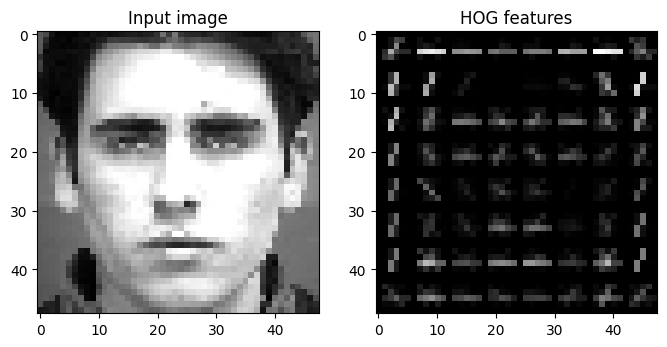

In [142]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(ck_images[1], cmap='gray')
plt.title('Input image')

plt.subplot(1, 2, 2)
plt.imshow(hog_X_ck[1], cmap='gray')
plt.title('HOG features')
plt.show()

In [143]:
# Using sklearn train test split to make training and test dataset
X_train_jaffa, X_test_jaffa, y_train_jaffa, y_test_jaffa = train_test_split(jaffe_X, jaffe_y, test_size=0.3, random_state=42)

X_train_jaffa = X_train_jaffa.reshape(X_train_jaffa.shape[0], -1)
X_test_jaffa = X_test_jaffa.reshape(X_test_jaffa.shape[0], -1)

X_train_jaffa_hog, X_test_jaffa_hog, y_train_jaffa, y_test_jaffa = train_test_split(hog_X_jaffe, jaffe_y, test_size=0.3, random_state=42)

X_train_jaffa_hog = X_train_jaffa_hog.reshape(X_train_jaffa_hog.shape[0], -1)
X_test_jaffa_hog = X_test_jaffa_hog.reshape(X_test_jaffa_hog.shape[0], -1)


In [144]:
# Split CK dataset
X_train_ck, X_test_ck, y_train_ck, y_test_ck = train_test_split(X_ck, y_ck, test_size=0.3, random_state=42)

# Flatten images
X_train_ck = X_train_ck.reshape(X_train_ck.shape[0], -1)
X_test_ck  = X_test_ck.reshape(X_test_ck.shape[0], -1)

# Split HOG features if available
X_train_ck_hog, X_test_ck_hog, y_train_ck, y_test_ck = train_test_split(hog_X_ck, y_ck, test_size=0.3, random_state=42)

# Flatten HOG features
X_train_ck_hog = X_train_ck_hog.reshape(X_train_ck_hog.shape[0], -1)
X_test_ck_hog  = X_test_ck_hog.reshape(X_test_ck_hog.shape[0], -1)


In [183]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = scaler.transform(X_train)

    X_test_scaled = scaler.fit_transform(X_test)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

X_train_jaffa_hog_s, X_test_jaffa_hog_s = scale_data(X_train_jaffa_hog, X_test_jaffa_hog)
X_train_ck_hog_s, X_test_ck_hog_s = scale_data(X_train_ck_hog, X_test_ck_hog)


In [155]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=3,
    min_samples_leaf=2,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    random_state=42
)

In [177]:
# Training the model on the face detected dataset
rf_model.fit(X_train_jaffa, y_train_jaffa)
rf_model.score(X_test_jaffa, y_test_jaffa)

0.7142857142857143

In [178]:
rf_model.fit(X_train_ck, y_train_ck)
rf_model.score(X_test_ck, y_test_ck)

0.7753623188405797

In [179]:
# Training the model on the HOG dataset
rf_model.fit(X_train_jaffa_hog, y_train_jaffa)
rf_model.score(X_test_jaffa_hog, y_test_jaffa)

0.625

In [180]:
rf_model.fit(X_train_jaffa_hog_s, y_train_jaffa)
rf_model.score(X_test_jaffa_hog_s, y_test_jaffa)

0.6785714285714286

In [181]:
rf_model.fit(X_train_ck_hog, y_train_ck)
rf_model.score(X_test_ck_hog, y_test_ck)

0.8007246376811594

In [182]:
rf_model.fit(X_train_ck_hog_s, y_train_ck)
rf_model.score(X_test_ck_hog_s, y_test_ck)

0.8079710144927537